# Matrix weight
This is to explore the higher characteristic dimension. 

In [1]:
# %%
import numpy as np
import pandas as pd
# import igraph as ig
import networkx as nx

# 3D plot
from mpl_toolkits import mplot3d

## Functions

In [2]:
# Generate rotation matrices
from itertools import combinations

def generate_random_rotation_matrix(k):
    A = np.eye(k)
    planes = list(combinations(range(k), 2))
    np.random.shuffle(planes)
    for i, j in planes:
        val = np.random.uniform(-1, 1)
        th = val * np.pi
        print("planes: ({}, {}), angle: {} pi".format(i,j,val))
        R = np.eye(k)
        R[i, i] = np.cos(th)
        R[i, j] = -np.sin(th)
        R[j, i] = np.sin(th)
        R[j, j] = np.cos(th)
        A = R @ A
    return A

In [3]:
def generate_rotation_noise_matrix(k, noise=0.):
    A = np.eye(k)
    planes = list(combinations(range(k), 2))
    np.random.shuffle(planes)
    for i, j in planes:
        val = np.random.normal(scale=noise)
        th = val * np.pi
        print("planes: ({}, {}), noise angle: {} pi".format(i,j,val))
        R = np.eye(k)
        R[i, i] = np.cos(th)
        R[i, j] = -np.sin(th)
        R[j, i] = np.sin(th)
        R[j, j] = np.cos(th)
        A = R @ A
    return A

In [4]:
def assign_rotation_matrix(src, trg):
    k, l = membership[src], membership[trg]
    if np.random.rand() < coherence:
        return com_com_rotation_matrix[(k, l)] # assign the community to community matrix
    else:
        return generate_rotation_noise_matrix(k=dim, noise=noise).dot(com_com_rotation_matrix[(k, l)])

## Consensus

### n_communities = 2

In [5]:
# Parameters
n_nodes = 80
n_communities = 2
pin, pout = 0.3, 0.3

assert n_nodes % n_communities == 0, "n_nodes must be divisible by n_communities"

# Generate a base network using the stochastic block model
pref_matrix = np.full((n_communities, n_communities), pout)
pref_matrix[np.diag_indices_from(pref_matrix)] = pin
block_sizes = [n_nodes // n_communities] * n_communities

In [6]:
g = nx.stochastic_block_model(block_sizes, pref_matrix, seed=0, directed=False)
A = nx.to_scipy_sparse_array(g)

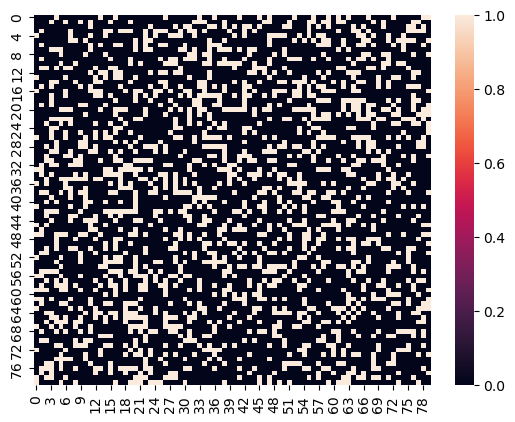

In [7]:
# %% Plot the network
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(A.todense())
plt.show()

In [8]:
# Sanity check
dim = 3

R = generate_random_rotation_matrix(k=dim)
assert np.all(np.isclose(R.T @ R, np.eye(dim))), "R is not orthonormal"

planes: (1, 2), angle: -0.1145716856445389 pi
planes: (0, 2), angle: 0.3266102753552298 pi
planes: (0, 1), angle: -0.19776011568673013 pi


In [9]:
# degree matrix
from scipy.sparse import diags

d = A.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [33]:
# inital characteristic vector for nodes
# s1 - choose a random position, and assign to nodes in one community
y_0_2d = np.random.rand(dim)
y_0_2d /= np.linalg.norm(y_0_2d)
print(y_0_2d)

[0.07593272 0.92591983 0.37000905]


In [34]:
# randomly assign a few nodes with nonzero characteristics at t=0
from random import sample

n_sel = [15, 20][1]
nodes_0 = sample(range(block_sizes[0]), n_sel)

In [35]:
row = []
col = [0]*(n_sel*dim)
data = []
for k in nodes_0:
    for ki in range(dim):
        row.append(k*dim+ki)
        data.append(y_0_2d[ki])

In [36]:
from scipy.sparse import csr_array, csc_matrix
y_0 = csc_matrix((data, (row, col)), shape=(n_nodes*dim, 1))

In [14]:
# Generate a set of random rotations for each pair of communities
from scipy import sparse

src, trg, _ = sparse.find(sparse.triu(A, 1)) # only edges
membership = np.digitize(np.arange(n_nodes), np.cumsum(block_sizes))

In [15]:
noise = 0.

# intially balanced configuration
# internal edges - identity matrix
com_com_rotation_matrix = {(l, l): np.eye(dim) for l in range(n_communities)} 
# external edges - first path random
com_com_rotation_matrix.update({(l, l+1): generate_random_rotation_matrix(k=dim) for l in range(n_communities-1)})
# external edges - others by existing ones
if n_communities == 2:
    com_com_rotation_matrix[(1,0)] = com_com_rotation_matrix[0,1].T

planes: (1, 2), angle: -0.3845155810670293 pi
planes: (0, 1), angle: 0.6105717974440192 pi
planes: (0, 2), angle: 0.43912327349345315 pi


In [17]:
coherence = 1.
# noise = 0.

In [19]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

In [20]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

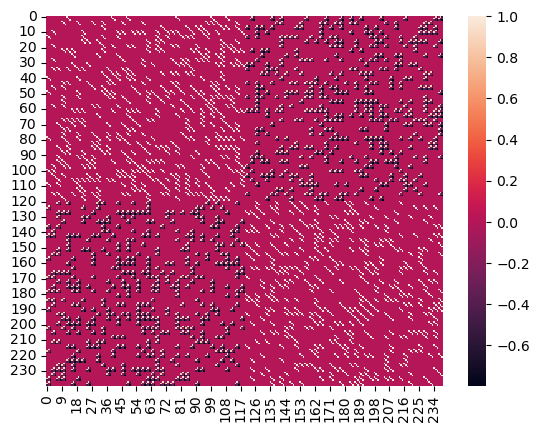

In [21]:
sns.heatmap(A_mat.todense())
plt.show()

In [22]:
# Laplacian
L_mat = D_mat - A_mat

In [37]:
# theoretical results
mat = y_0.toarray().reshape(n_nodes, dim)
y_0_bar = np.sum([assign_rotation_matrix(0, k).dot(mat[k, :]) for k in range(n_nodes)], axis=0)

y_star = []
for c in range(n_communities):
    y_star.append(com_com_rotation_matrix[(0, c)].T.dot(y_0_bar)/n_nodes)
# y_1 = com_com_rotation_matrix[(0, 0)].dot(y_0_bar)/n_nodes
# y_2 = com_com_rotation_matrix[(0, 1)].T.dot(y_0_bar)/n_nodes
print("C1:", y_star[0])
print("C2:", y_star[1])

C1: [0.01898318 0.23147996 0.09250226]
C2: [ 0.18550926 -0.05849101 -0.15705132]


In [39]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

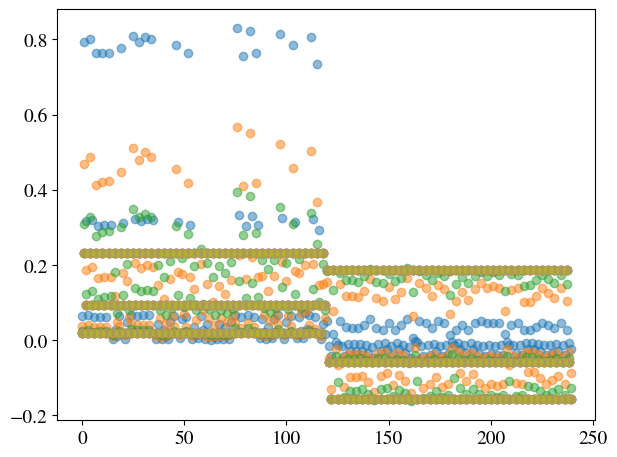

In [40]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

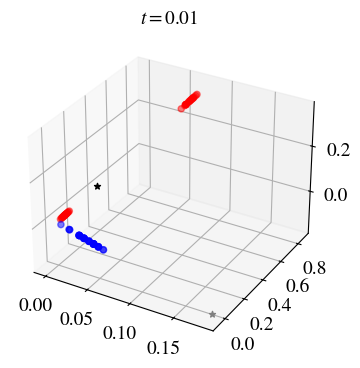

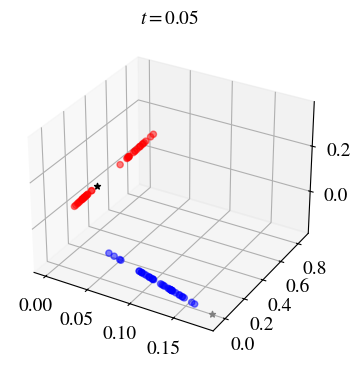

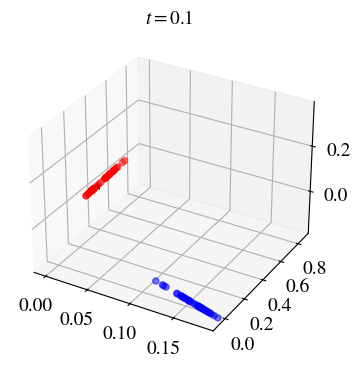

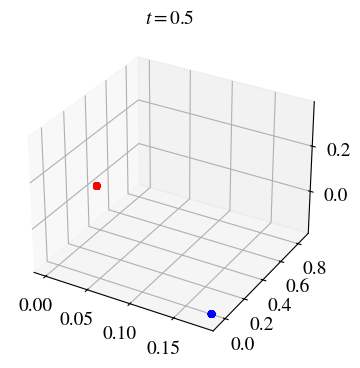

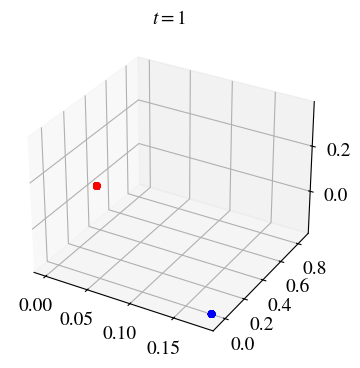

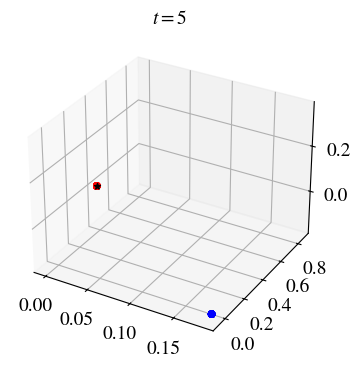

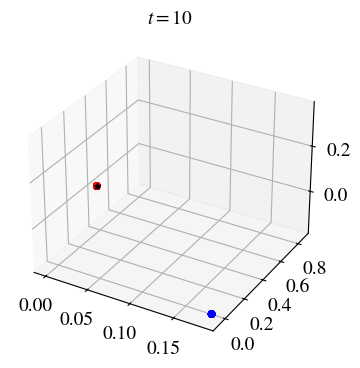

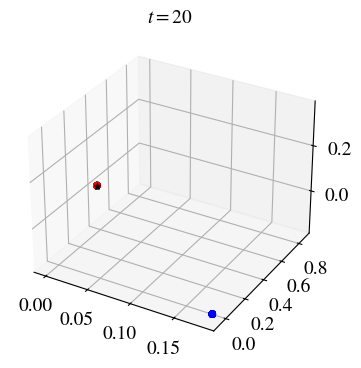

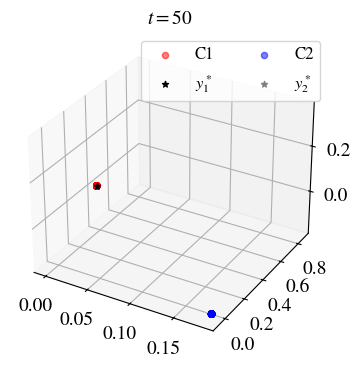

In [44]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.01, 0.19])
    ax.set_ylim([-0.1, 0.9])
    ax.set_zlim([-0.18, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=2, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
# 

#### Adding some noise

In [45]:
coherence = .8
noise = 0.1

In [46]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 1), noise angle: 0.16584185868514312 pi
planes: (0, 2), noise angle: -0.05580507919884309 pi
planes: (1, 2), noise angle: 0.02570036109669878 pi
planes: (0, 1), noise angle: -0.03196335559018688 pi
planes: (0, 2), noise angle: -0.0045758351209542695 pi
planes: (1, 2), noise angle: 0.09994298637660531 pi
planes: (0, 1), noise angle: -0.020586504793805718 pi
planes: (1, 2), noise angle: 0.0021114468978059454 pi
planes: (0, 2), noise angle: -0.04081179848865963 pi
planes: (0, 1), noise angle: 0.023865994305420225 pi
planes: (0, 2), noise angle: -0.1077340490788189 pi
planes: (1, 2), noise angle: -0.022178811085137334 pi
planes: (0, 1), noise angle: -0.043843876357797296 pi
planes: (1, 2), noise angle: 0.2058336251554844 pi
planes: (0, 2), noise angle: -0.054672709917694996 pi
planes: (0, 2), noise angle: 0.04434284634165634 pi
planes: (0, 1), noise angle: -0.010156721517923885 pi
planes: (1, 2), noise angle: -0.09301027386294097 pi
planes: (1, 2), noise angle: 0.08186886732163

In [47]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

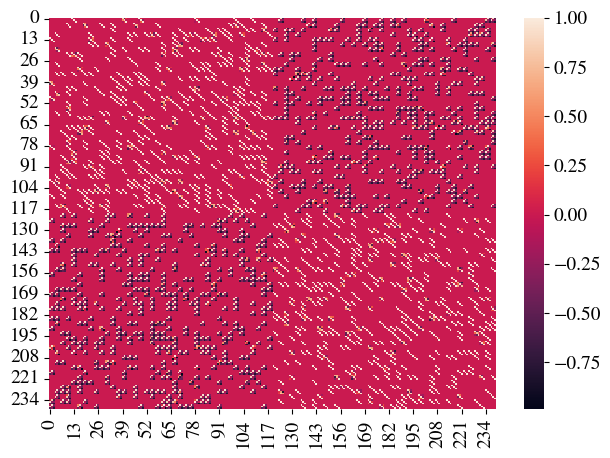

In [48]:
sns.heatmap(A_mat.todense())
plt.show()

In [49]:
# Laplacian
L_mat = D_mat - A_mat

In [50]:
# consensus dynamics
from scipy.sparse.linalg import expm

ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

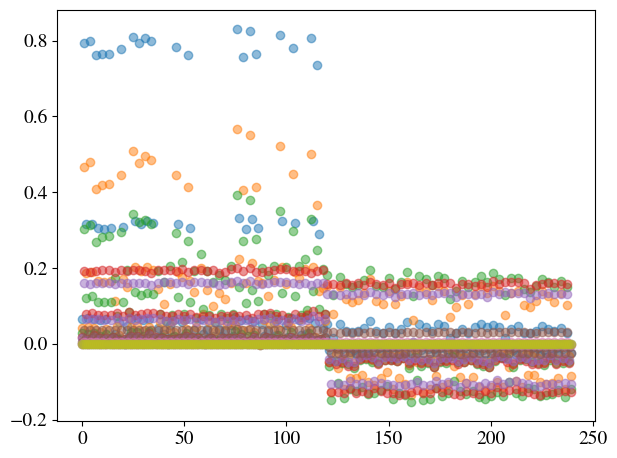

In [51]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

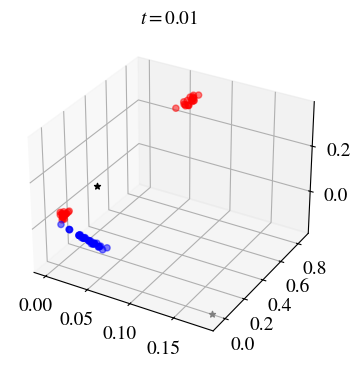

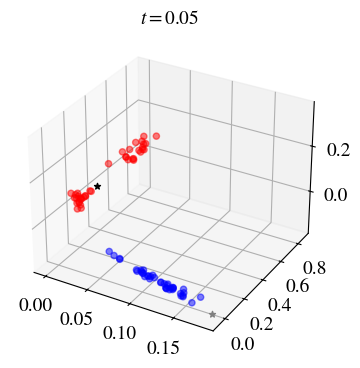

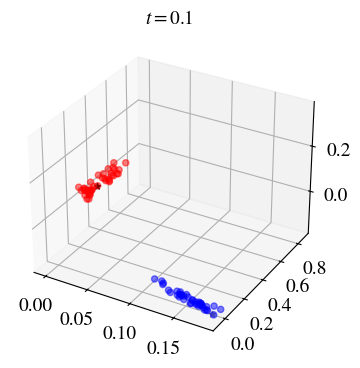

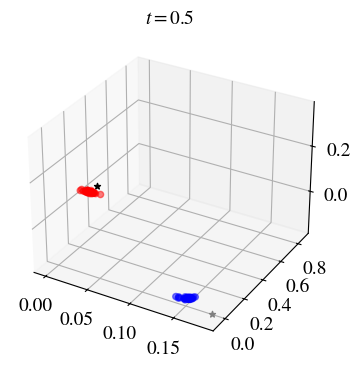

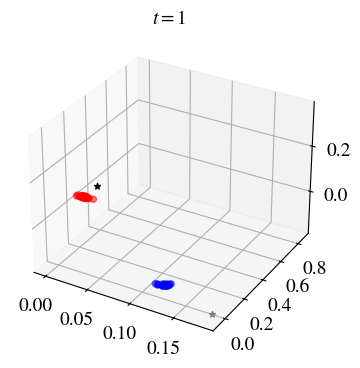

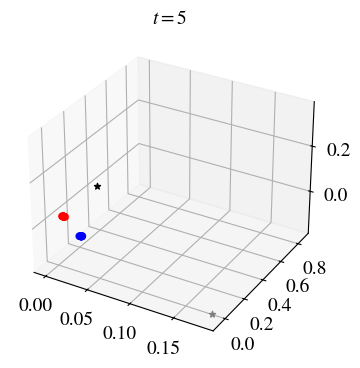

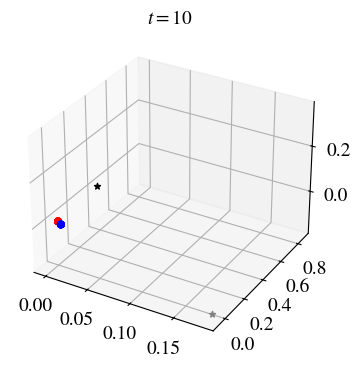

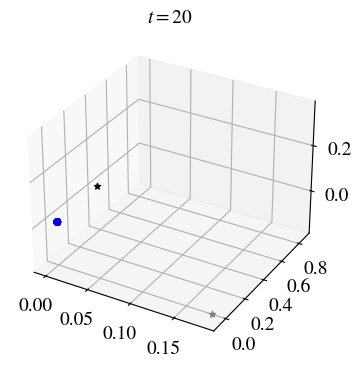

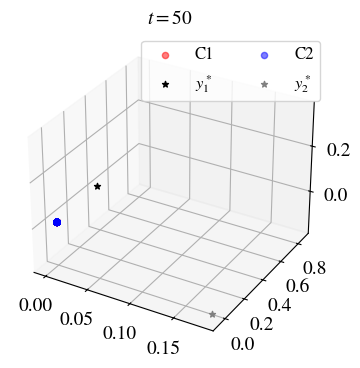

In [54]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.01, 0.19])
    ax.set_ylim([-0.1, 0.9])
    ax.set_zlim([-0.18, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=2, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
# 

#### Reducing p_out

In [86]:
# randomly remove edges from g
pout2 = [0.1, 0.03, 0.01][0]
pcut = (pout - pout2)/pout
print("edges to cut:", pcut)

edges to cut: 0.6666666666666666


In [87]:
g2 = g.copy()
edges_out = [(k,l) for k,l in zip(src, trg) if membership[k] != membership[l]]
print("#edges out:", len(edges_out))
n_cut = int(len(edges_out)*pcut)
print("#edges to cut", n_cut)

#edges out: 468
#edges to cut 312


In [88]:
from random import sample

ind_cut = sample(range(len(edges_out)), n_cut)
edges_cut = [edges_out[k] for k in ind_cut]
g2.remove_edges_from(edges_cut)

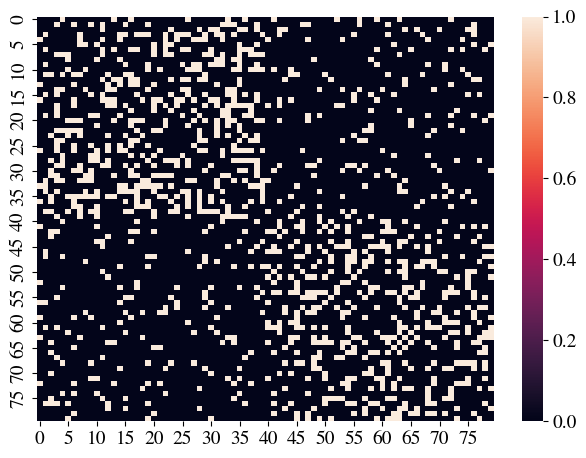

In [89]:
A = nx.to_scipy_sparse_array(g2)
sns.heatmap(A.todense())
plt.show()

In [90]:
# degree matrix
from scipy.sparse import diags

d = A.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [91]:
src2, trg2, _ = sparse.find(sparse.triu(A, 1)) # only edges

In [92]:
coherence = .8
noise = 0.1

In [93]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src2, trg2):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 1), noise angle: 0.009887816473990467 pi
planes: (0, 2), noise angle: -0.16158307681386075 pi
planes: (1, 2), noise angle: -0.19640856299830461 pi
planes: (0, 1), noise angle: 0.04071928925818294 pi
planes: (1, 2), noise angle: -0.08915264823726296 pi
planes: (0, 2), noise angle: 0.09752972917506383 pi
planes: (0, 2), noise angle: -0.027979063915906384 pi
planes: (1, 2), noise angle: 0.08465624186250315 pi
planes: (0, 1), noise angle: -0.15690259926842265 pi
planes: (0, 2), noise angle: 0.0600379737776775 pi
planes: (1, 2), noise angle: 0.25245183058551834 pi
planes: (0, 1), noise angle: 0.04129633684552475 pi
planes: (0, 1), noise angle: -0.03583805014253375 pi
planes: (1, 2), noise angle: 0.1885344809820561 pi
planes: (0, 2), noise angle: -0.021964696077038073 pi
planes: (0, 1), noise angle: 0.07971416038432563 pi
planes: (0, 2), noise angle: 0.10984995931488145 pi
planes: (1, 2), noise angle: 0.058711084437077204 pi
planes: (0, 1), noise angle: 0.0057102427151652126 pi
p

In [94]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

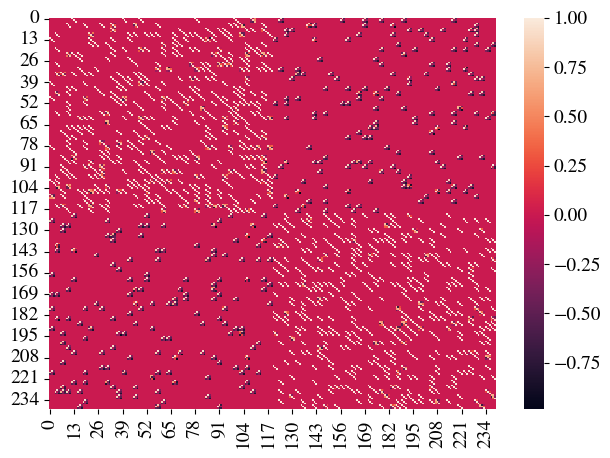

In [95]:
sns.heatmap(A_mat.todense())
plt.show()

In [96]:
# Laplacian
L_mat = D_mat - A_mat

In [97]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
# ts = np.arange(1.6, 3., 0.1)
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

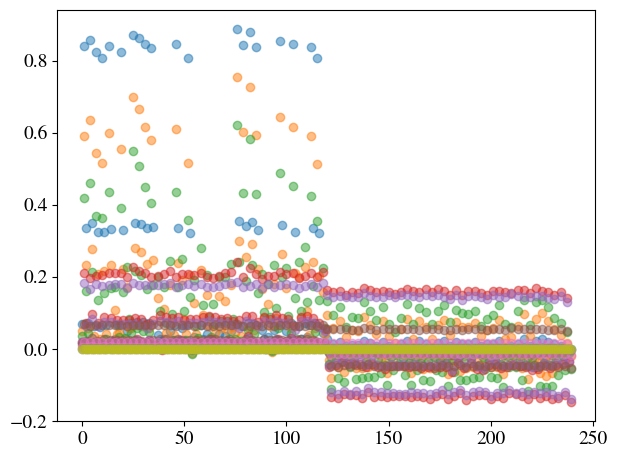

In [98]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

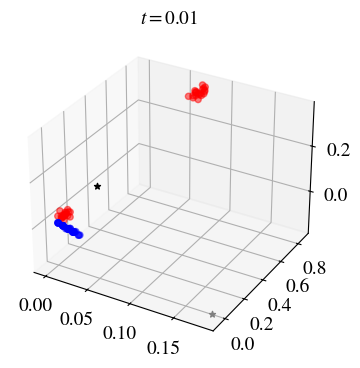

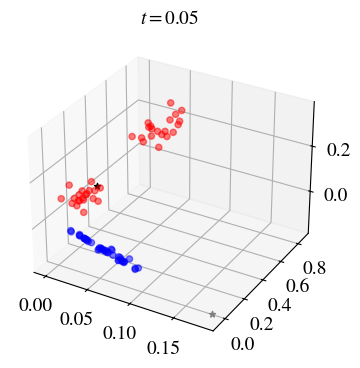

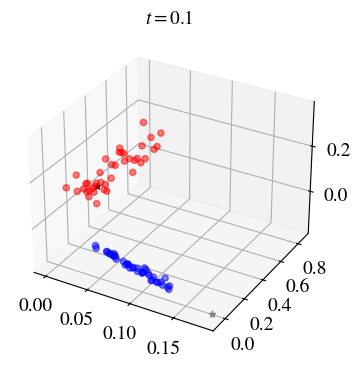

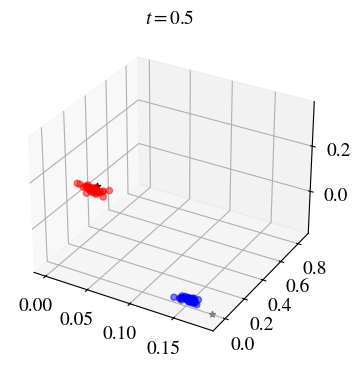

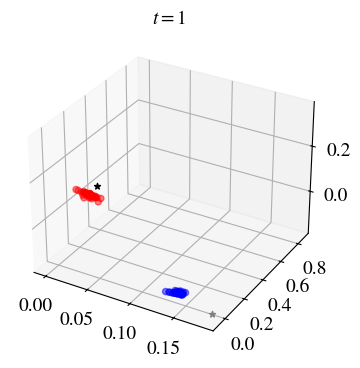

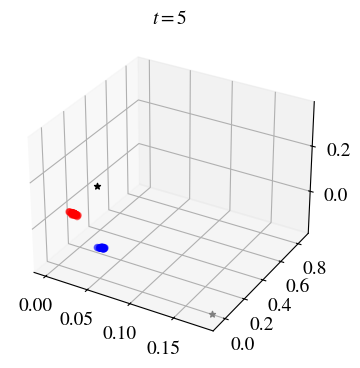

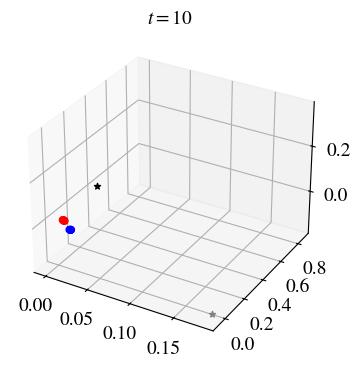

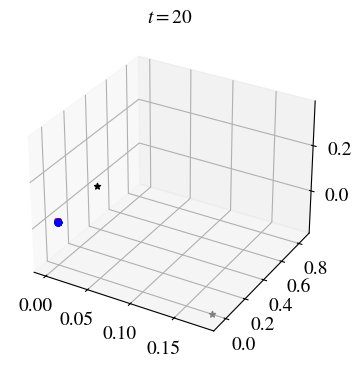

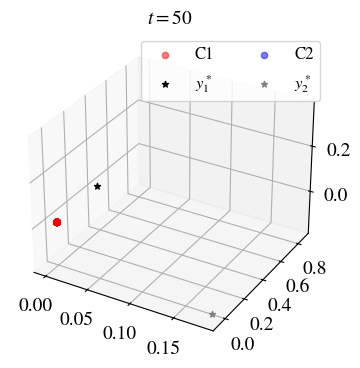

In [101]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.01, 0.19])
    ax.set_ylim([-0.1, 0.9])
    ax.set_zlim([-0.18, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=2, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
# 

### n_communities = 3

In [268]:
# Parameters
n_nodes = 120
n_communities = 3
pin, pout = 0.3, 0.3

assert n_nodes % n_communities == 0, "n_nodes must be divisible by n_communities"

# Generate a base network using the stochastic block model
pref_matrix = np.full((n_communities, n_communities), pout)
pref_matrix[np.diag_indices_from(pref_matrix)] = pin
block_sizes = [n_nodes // n_communities] * n_communities

In [269]:
g = nx.stochastic_block_model(block_sizes, pref_matrix, seed=0, directed=False)
A = nx.to_scipy_sparse_array(g)

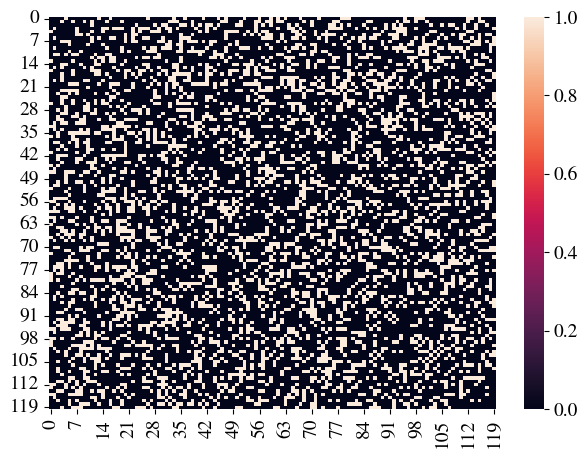

In [104]:
# %% Plot the network
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(A.todense())
plt.show()

In [105]:
# Sanity check
dim = 3

R = generate_random_rotation_matrix(k=dim)
assert np.all(np.isclose(R.T @ R, np.eye(dim))), "R is not orthonormal"

planes: (0, 1), angle: -0.3926234822644388 pi
planes: (1, 2), angle: 0.8983884059256249 pi
planes: (0, 2), angle: -0.9934222611487376 pi


In [106]:
# degree matrix
from scipy.sparse import diags

d = A.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [192]:
# inital characteristic vector for nodes
# s1 - choose a random position, and assign to nodes in one community
y_0_c1 = np.random.uniform(-1,1,dim)
y_0_c1 /= np.linalg.norm(y_0_c1)
print(y_0_c1)

[-0.86578297 -0.29300539  0.40566943]


In [193]:
y_0_c2 = np.random.uniform(-1,1,dim)
y_0_c2 /= np.linalg.norm(y_0_c2)
print(y_0_c2)

[-0.92819223  0.11313401 -0.35448538]


In [194]:
# y_0_c3 = -y_0_c1
# y_0_c3[-int(dim/2):] = -y_0_c2[-int(dim/2):] #negate half c1 and halrf c2
# y_0_c3 /= np.linalg.norm(y_0_c3)
# print(y_0_c3)

[0.88313381 0.2988774  0.36158949]


In [195]:
# randomly assign a few nodes with nonzero characteristics at t=0
from random import sample

n_sel = [15, 20][1]
nodes_1 = sample(range(block_sizes[0]), n_sel)
nodes_2 = sample(range(block_sizes[0], block_sizes[0]+block_sizes[1]), n_sel)
# nodes_3 = sample(range(block_sizes[1], block_sizes[1]+block_sizes[2]), n_sel)

In [202]:
row = []
col = [0]*(2*n_sel*dim)
data = []
for k in nodes_1:
    for ki in range(dim):
        row.append(k*dim+ki)
        data.append(y_0_c1[ki])
for k in nodes_2:
    for ki in range(dim):
        row.append(k*dim+ki)
        data.append(y_0_c2[ki])
# for k in nodes_3:
#     for ki in range(dim):
#         row.append(k*dim+ki)
#         data.append(y_0_c3[ki])

In [203]:
from scipy.sparse import csr_array, csc_matrix
y_0 = csc_matrix((data, (row, col)), shape=(n_nodes*dim, 1))

In [112]:
# Generate a set of random rotations for each pair of communities
from scipy import sparse

src, trg, _ = sparse.find(sparse.triu(A, 1)) # only edges
membership = np.digitize(np.arange(n_nodes), np.cumsum(block_sizes))

In [114]:
noise = 0.

# intially balanced configuration
# internal edges - identity matrix
com_com_rotation_matrix = {(l, l): np.eye(dim) for l in range(n_communities)} 
# external edges - first path random
com_com_rotation_matrix.update({(l, l+1): generate_random_rotation_matrix(k=dim) for l in range(n_communities-1)})
# external edges - others by existing ones
if n_communities == 2:
    com_com_rotation_matrix[(1,0)] = com_com_rotation_matrix[0,1].T
elif n_communities == 3:
    # close the cycle
    com_com_rotation_matrix[(0,2)] = com_com_rotation_matrix[(0,1)].dot(com_com_rotation_matrix[(1,2)])
    # assign others as the transpose
    for i in range(1, n_communities):
        for j in range(i):
            com_com_rotation_matrix[(i,j)] = com_com_rotation_matrix[j,i].T

planes: (0, 2), angle: 0.33138963039233293 pi
planes: (1, 2), angle: 0.24649046036649302 pi
planes: (0, 1), angle: 0.45173381273411684 pi
planes: (1, 2), angle: -0.49081863942598214 pi
planes: (0, 1), angle: -0.5501028634594278 pi
planes: (0, 2), angle: 0.27312374198306144 pi


In [115]:
coherence = 1.
# noise = 0.

In [116]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

In [117]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

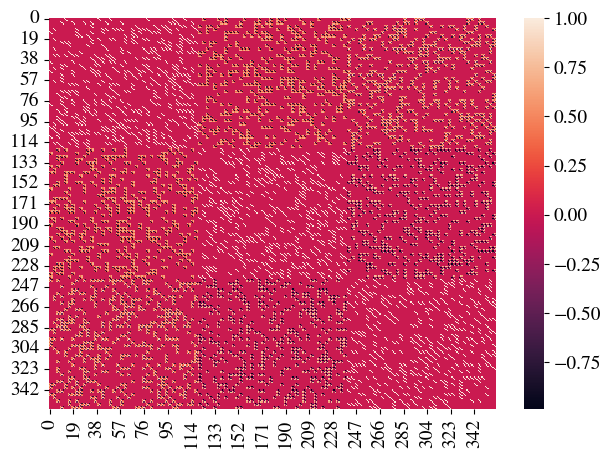

In [118]:
sns.heatmap(A_mat.todense())
plt.show()

In [119]:
# Laplacian
L_mat = D_mat - A_mat

In [204]:
# theoretical results
mat = y_0.toarray().reshape(n_nodes, dim)
y_0_bar = np.sum([assign_rotation_matrix(0, k).dot(mat[k, :]) for k in range(n_nodes)], axis=0)

y_star = []
for c in range(n_communities):
    y_star.append(com_com_rotation_matrix[(0, c)].T.dot(y_0_bar)/n_nodes)
# y_1 = com_com_rotation_matrix[(0, 0)].dot(y_0_bar)/n_nodes
# y_2 = com_com_rotation_matrix[(0, 1)].T.dot(y_0_bar)/n_nodes
print("C1:", y_star[0])
print("C2:", y_star[1])
print("C3:", y_star[2])

C1: [-0.27464262 -0.05641399 -0.035976  ]
C2: [-0.23001859  0.16282974 -0.02198426]
C3: [-0.13463172 -0.16507579 -0.1858216 ]


In [208]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01]
# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

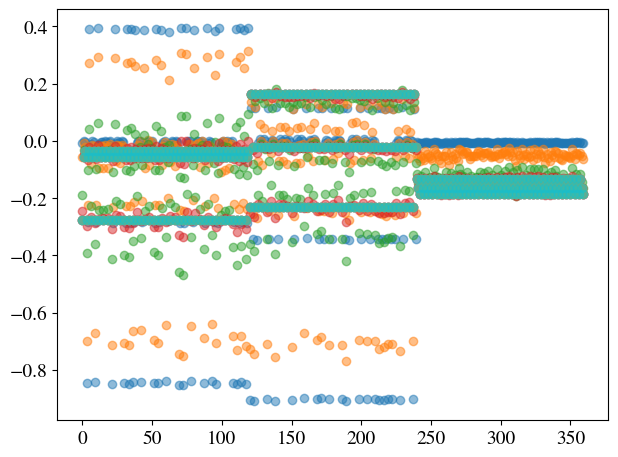

In [209]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

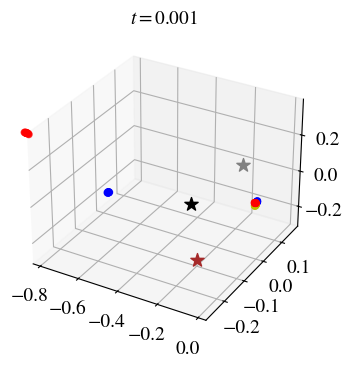

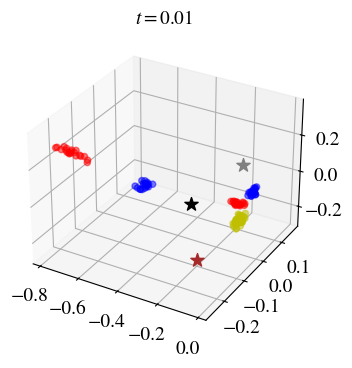

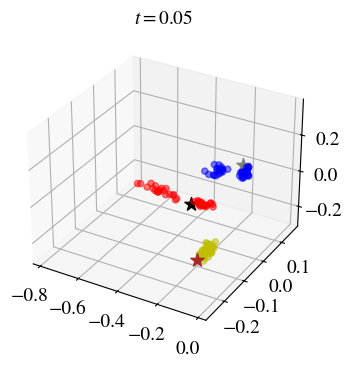

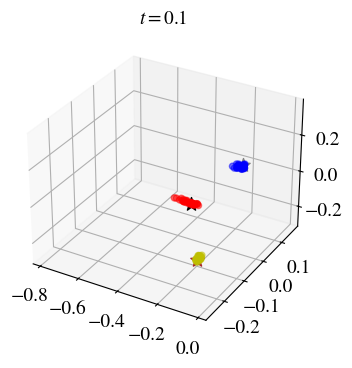

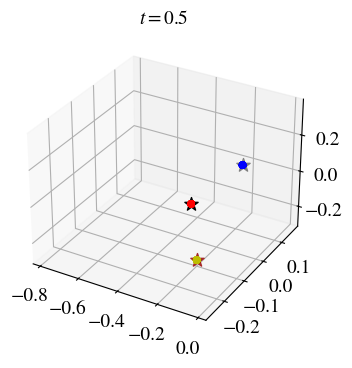

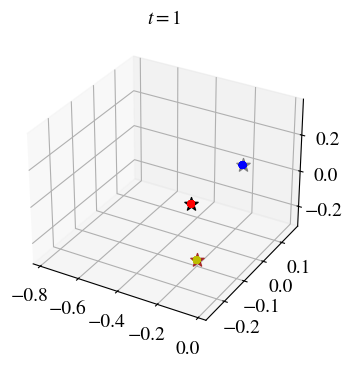

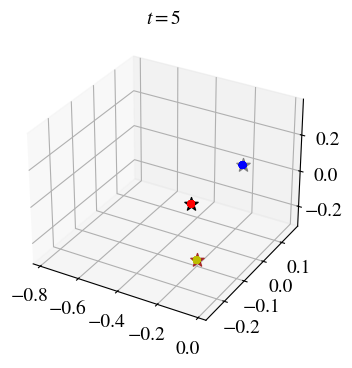

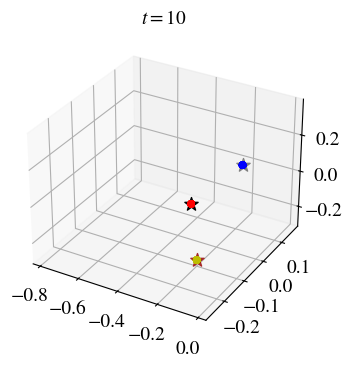

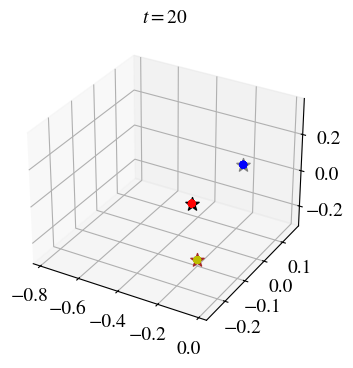

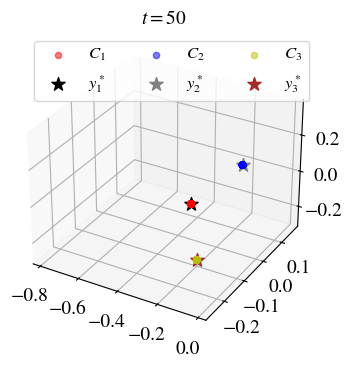

In [212]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', s=100, color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.82, 0.02])
    ax.set_ylim([-0.28, 0.18])
    ax.set_zlim([-0.3, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
# 

#### Adding some noise

In [213]:
coherence = .8
noise = 0.1

In [214]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 1), noise angle: 0.12329130877316988 pi
planes: (0, 2), noise angle: -0.11401327772833324 pi
planes: (1, 2), noise angle: 0.10029287656646445 pi
planes: (1, 2), noise angle: -0.17294552662093485 pi
planes: (0, 1), noise angle: -0.11946137286846142 pi
planes: (0, 2), noise angle: -0.016746463945076118 pi
planes: (1, 2), noise angle: 0.0665153480686497 pi
planes: (0, 1), noise angle: 0.019119379511712192 pi
planes: (0, 2), noise angle: 0.07902700578563951 pi
planes: (0, 2), noise angle: 0.0003221378375306854 pi
planes: (0, 1), noise angle: 0.04172392871297288 pi
planes: (1, 2), noise angle: -0.13411823959332078 pi
planes: (0, 1), noise angle: 0.04308772868856174 pi
planes: (1, 2), noise angle: 0.06773893361734906 pi
planes: (0, 2), noise angle: 0.0433363473257743 pi
planes: (0, 1), noise angle: -0.02290297310599383 pi
planes: (0, 2), noise angle: -0.01812976980427762 pi
planes: (1, 2), noise angle: -0.1177016841477021 pi
planes: (1, 2), noise angle: 0.018167780812194632 pi
pl

In [215]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

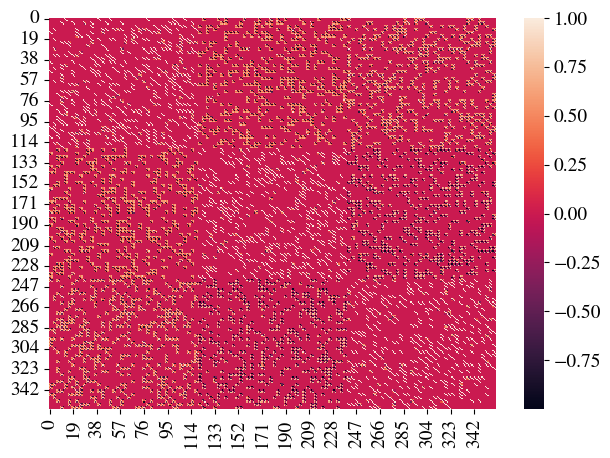

In [216]:
sns.heatmap(A_mat.todense())
plt.show()

In [217]:
# Laplacian
L_mat = D_mat - A_mat

In [222]:
# consensus dynamics
from scipy.sparse.linalg import expm

ts = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

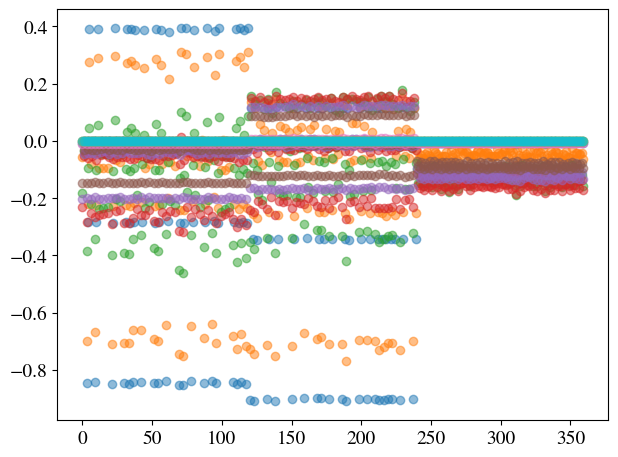

In [223]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

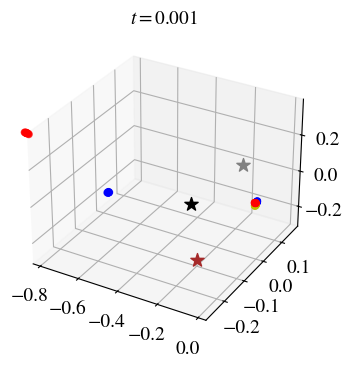

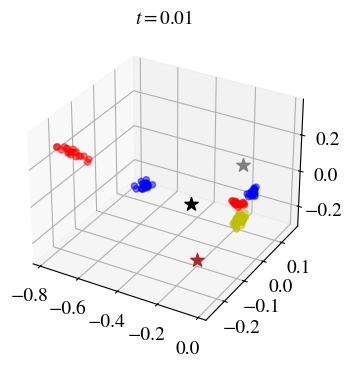

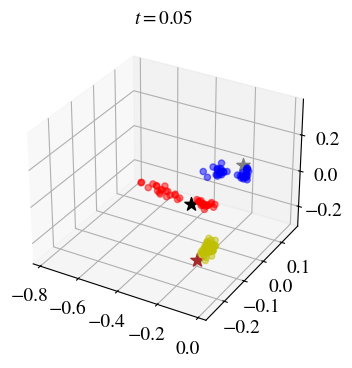

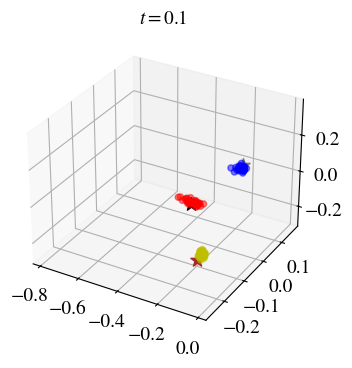

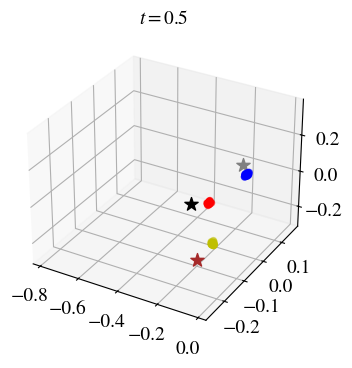

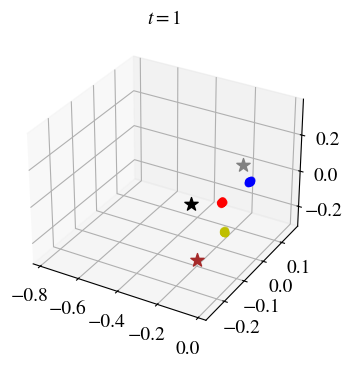

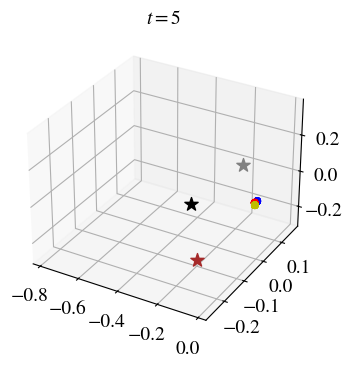

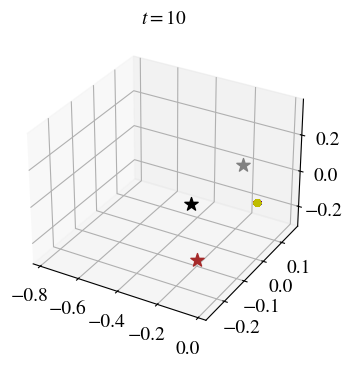

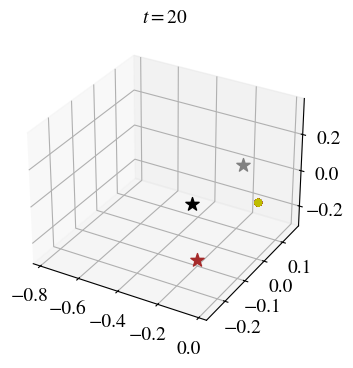

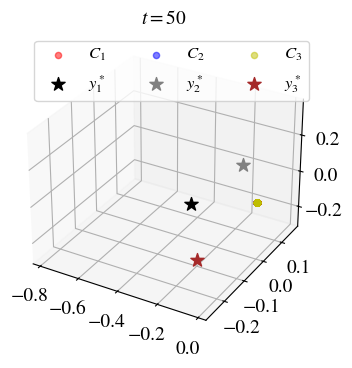

In [225]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', s=100, color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.82, 0.02])
    ax.set_ylim([-0.28, 0.18])
    ax.set_zlim([-0.3, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
# 

#### Reducing p_out

In [226]:
# randomly remove edges from g
pout2 = [0.1, 0.03, 0.01][0]
pcut = (pout - pout2)/pout
print("edges to cut:", pcut)

edges to cut: 0.6666666666666666


In [227]:
g2 = g.copy()
edges_out = [(k,l) for k,l in zip(src, trg) if membership[k] != membership[l]]
print("#edges out:", len(edges_out))
n_cut = int(len(edges_out)*pcut)
print("#edges to cut", n_cut)

#edges out: 1432
#edges to cut 954


In [228]:
from random import sample

ind_cut = sample(range(len(edges_out)), n_cut)
edges_cut = [edges_out[k] for k in ind_cut]
g2.remove_edges_from(edges_cut)

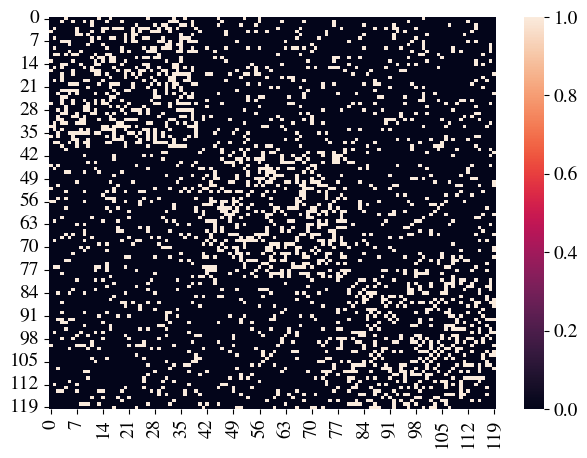

In [229]:
A2 = nx.to_scipy_sparse_array(g2)
sns.heatmap(A2.todense())
plt.show()

In [230]:
# degree matrix
from scipy.sparse import diags

d = A2.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [231]:
src2, trg2, _ = sparse.find(sparse.triu(A, 1)) # only edges

In [232]:
coherence = .8
noise = 0.1

In [233]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src2, trg2):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 2), noise angle: 0.15998209753074574 pi
planes: (0, 1), noise angle: -0.05511212511020774 pi
planes: (1, 2), noise angle: 0.14644497705521453 pi
planes: (1, 2), noise angle: 0.025652585852274524 pi
planes: (0, 1), noise angle: -0.0006064807151826406 pi
planes: (0, 2), noise angle: -0.08575772534320969 pi
planes: (1, 2), noise angle: -0.10170157655083328 pi
planes: (0, 2), noise angle: 0.07188513603729338 pi
planes: (0, 1), noise angle: -0.10871527952862106 pi
planes: (0, 1), noise angle: -0.13281649370699203 pi
planes: (0, 2), noise angle: 0.007887358364082291 pi
planes: (1, 2), noise angle: 0.07095007715944245 pi
planes: (0, 1), noise angle: -0.07128764246012373 pi
planes: (0, 2), noise angle: -0.02290210630429336 pi
planes: (1, 2), noise angle: -0.23072732373185412 pi
planes: (1, 2), noise angle: 0.15366945221511197 pi
planes: (0, 2), noise angle: 0.01691574909915335 pi
planes: (0, 1), noise angle: -0.01690181664816131 pi
planes: (1, 2), noise angle: 0.12190811634851327 p

In [234]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

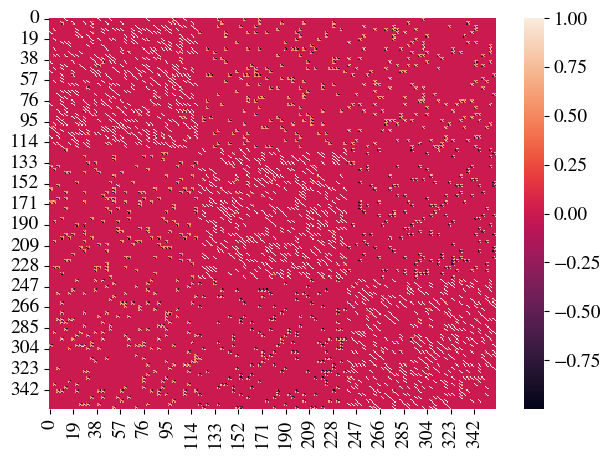

In [235]:
sns.heatmap(A_mat.todense())
plt.show()

In [236]:
# Laplacian
L_mat = D_mat - A_mat

In [237]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
# ts = np.arange(1.6, 3., 0.1)
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

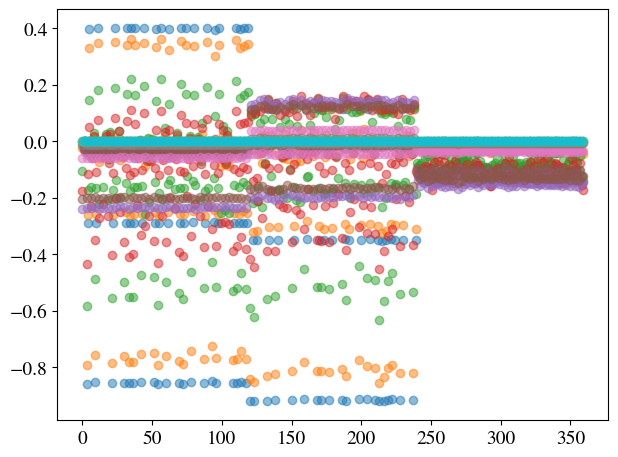

In [238]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

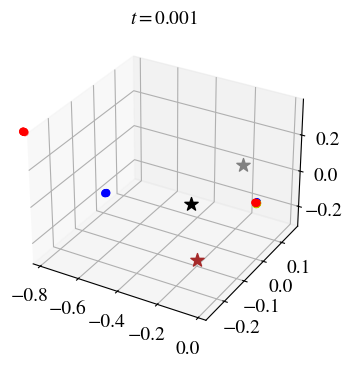

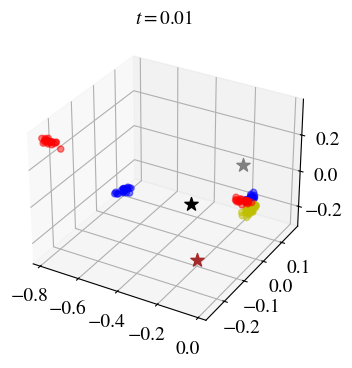

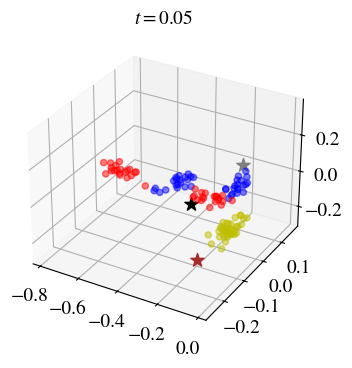

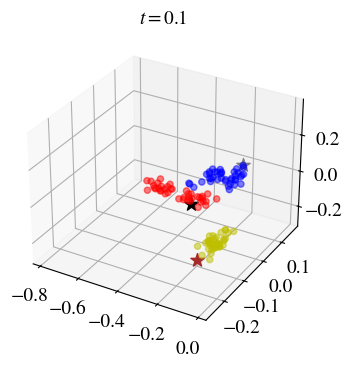

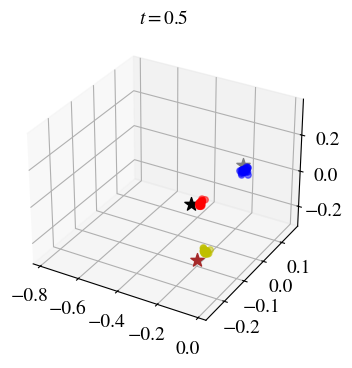

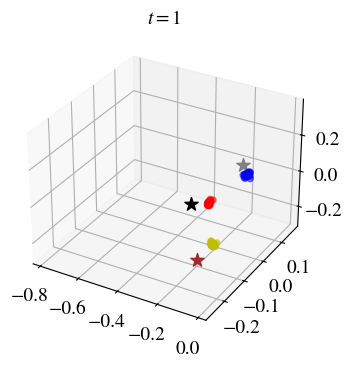

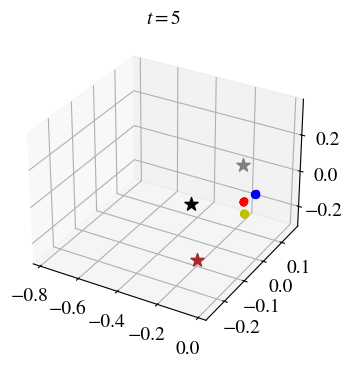

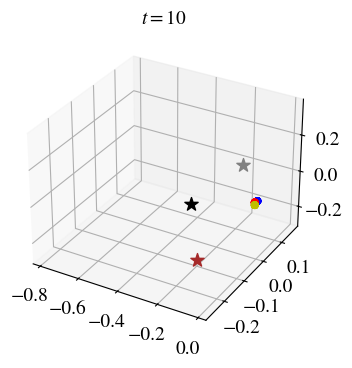

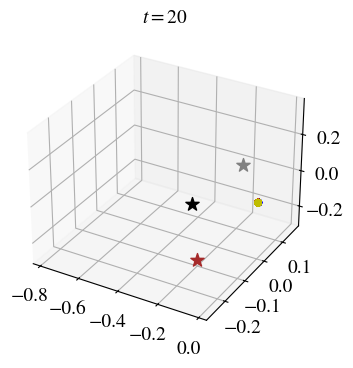

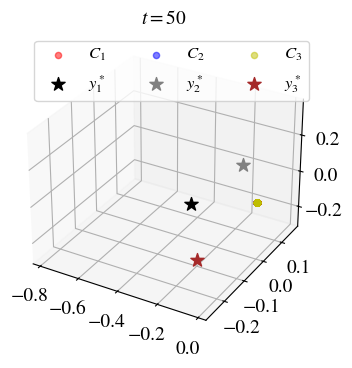

In [240]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', s=100, color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.82, 0.02])
    ax.set_ylim([-0.28, 0.18])
    ax.set_zlim([-0.3, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout2, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
# 

## Random walks

### n_communities = 3

In [268]:
# Parameters
n_nodes = 120
n_communities = 3
pin, pout = 0.3, 0.3

assert n_nodes % n_communities == 0, "n_nodes must be divisible by n_communities"

# Generate a base network using the stochastic block model
pref_matrix = np.full((n_communities, n_communities), pout)
pref_matrix[np.diag_indices_from(pref_matrix)] = pin
block_sizes = [n_nodes // n_communities] * n_communities

In [269]:
g = nx.stochastic_block_model(block_sizes, pref_matrix, seed=0, directed=False)
A = nx.to_scipy_sparse_array(g)

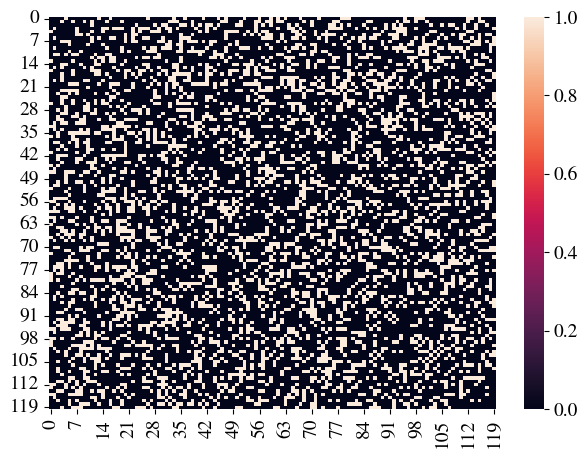

In [104]:
# %% Plot the network
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(A.todense())
plt.show()

In [ ]:
src, trg, _ = sparse.find(sparse.triu(A, 1)) # only edges
membership = np.digitize(np.arange(n_nodes), np.cumsum(block_sizes))

In [331]:
# let's maintain the same rotation matrices as before
coherence = 1.
noise = 0.

In [332]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

In [333]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

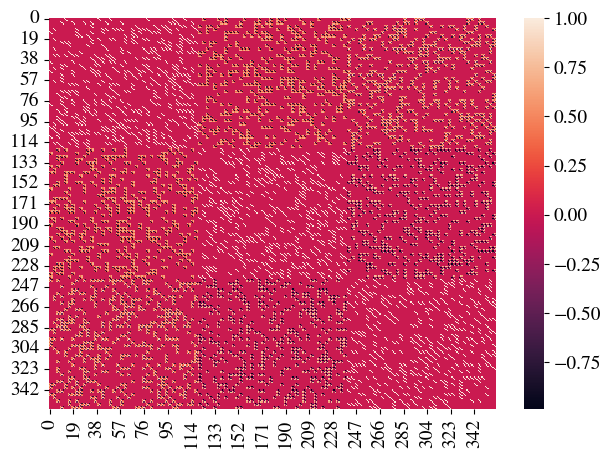

In [334]:
sns.heatmap(A_mat.todense())
plt.show()

In [270]:
d = A.sum(axis=1)
d2 = np.repeat(d, dim).astype(float)
Dinv_mat = diags(1/d2, 0, format='csc')

In [335]:
# matrix transition matrix
P_mat = Dinv_mat @ A_mat

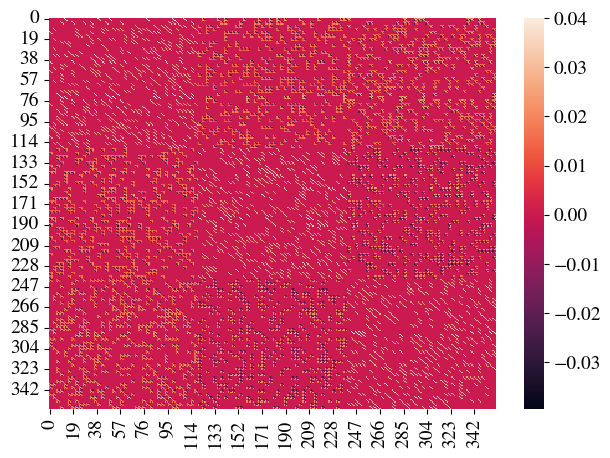

In [336]:
sns.heatmap(P_mat.todense())
plt.show()

In [276]:
# theoretical results
n_edges = g.number_of_edges()
mat = y_0.toarray().reshape(n_nodes, dim)
y_0_bar = np.sum([assign_rotation_matrix(0, k).dot(mat[k, :]) for k in range(n_nodes)], axis=0)

y_star = []
for c in range(n_communities):
    y_star.append(com_com_rotation_matrix[(0, c)].T.dot(y_0_bar)/(2*n_edges)) # ignoring the degree
# y_1 = com_com_rotation_matrix[(0, 0)].dot(y_0_bar)/n_nodes
# y_2 = com_com_rotation_matrix[(0, 1)].T.dot(y_0_bar)/n_nodes
print("C1:", y_star[0])
print("C2:", y_star[1])
print("C3:", y_star[2])

C1: [-0.0078432  -0.00161106 -0.0010274 ]
C2: [-0.00656883  0.00465006 -0.00062782]
C3: [-0.00384479 -0.00471421 -0.00530666]


In [337]:
# random walk dynamics
from scipy.sparse.linalg import expm

ts_all = np.arange(500)
res = [y_0]

y_tT = y_0.T
for t in ts_all:
    y_tT = y_tT @ P_mat
    res.append(y_tT.T)
#     plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)

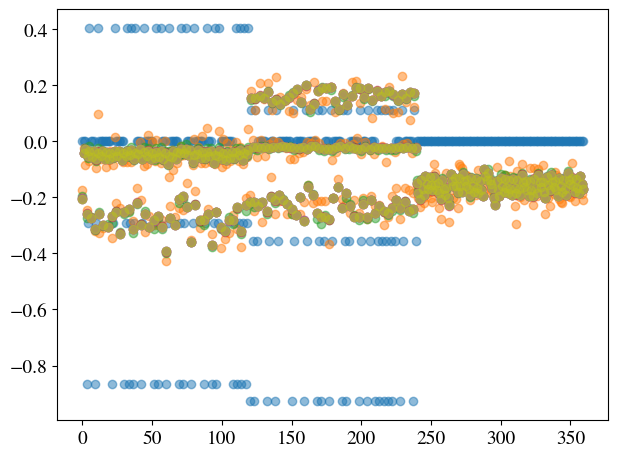

In [338]:
# output the results
# ts = [0, 1, 2, 3, 50]
ts = [0, 1, 2, 3, 5, 10, 50, 100, 500]

for t in ts:
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

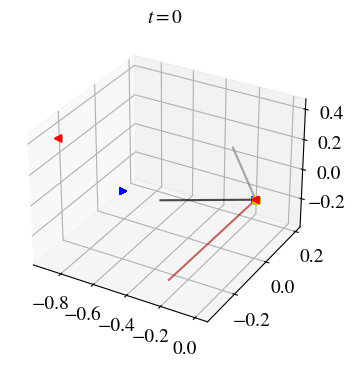

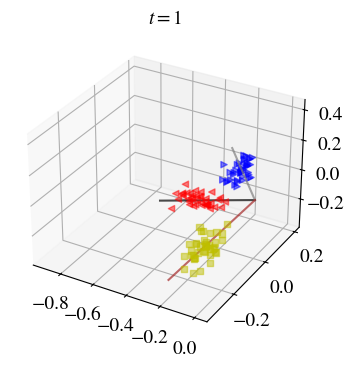

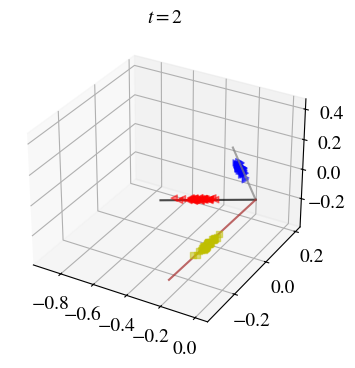

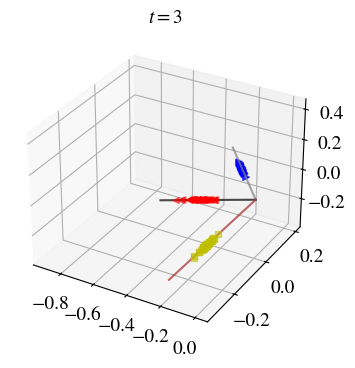

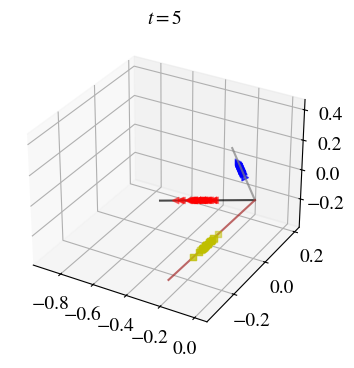

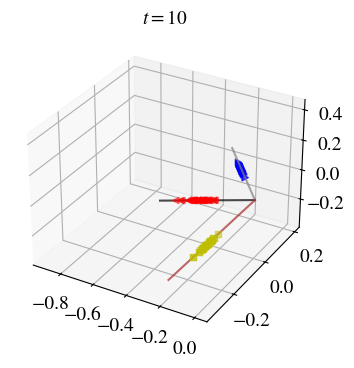

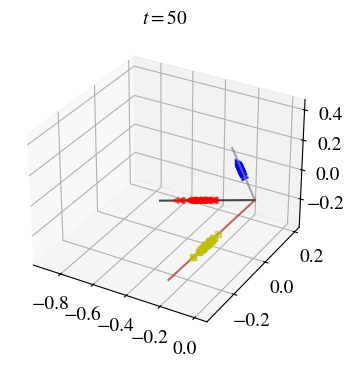

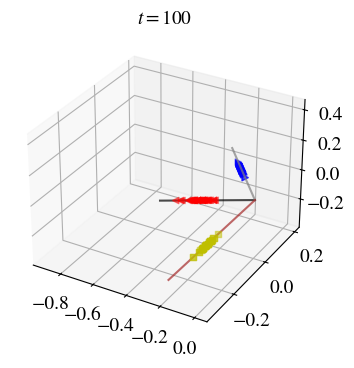

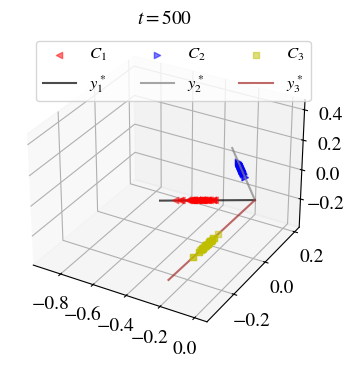

In [339]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
fac = 60
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']
markers = ['<', '>', 's']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(2):
# for ti in range(len(ts)-5, len(ts)):
for ti in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    t = ts[ti]
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], 
                   color=colors[c], marker=markers[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.plot3D([0, y_star[c][0]*fac], 
                  [0, y_star[c][1]*fac],
                  [0, y_star[c][2]*fac], 
                  color=colors_m[c], label=r'$y_{}^*$'.format(c+1), alpha=0.7)
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(t))
    ax.set_xlim([-0.95, 0.05])
    ax.set_ylim([-0.35, 0.22])
    ax.set_zlim([-0.38, 0.45])
    if ti == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('rw-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, ti), dpi=300, bbox_inches='tight')
    plt.show()
# 

#### Add some noise

In [305]:
coherence = .8
noise = 0.1

In [306]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (1, 2), noise angle: -0.066402904388128 pi
planes: (0, 1), noise angle: 0.10617266759535 pi
planes: (0, 2), noise angle: -0.00433671816629887 pi
planes: (0, 1), noise angle: 0.10683081087971497 pi
planes: (1, 2), noise angle: 0.047937889143194135 pi
planes: (0, 2), noise angle: -0.10830109911033765 pi
planes: (1, 2), noise angle: -0.06016442606833003 pi
planes: (0, 1), noise angle: -0.029854392314577306 pi
planes: (0, 2), noise angle: 0.03998874868749307 pi
planes: (0, 1), noise angle: -0.054912346396790816 pi
planes: (1, 2), noise angle: -0.07455548286026079 pi
planes: (0, 2), noise angle: -0.022756312814327096 pi
planes: (1, 2), noise angle: -0.00804824925677657 pi
planes: (0, 1), noise angle: -0.01105883454181265 pi
planes: (0, 2), noise angle: 0.03653739208448136 pi
planes: (0, 2), noise angle: 0.015435880564806121 pi
planes: (1, 2), noise angle: 0.1674932811386629 pi
planes: (0, 1), noise angle: -0.026385959113379178 pi
planes: (0, 2), noise angle: 0.14187930821801154 pi
p

In [307]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

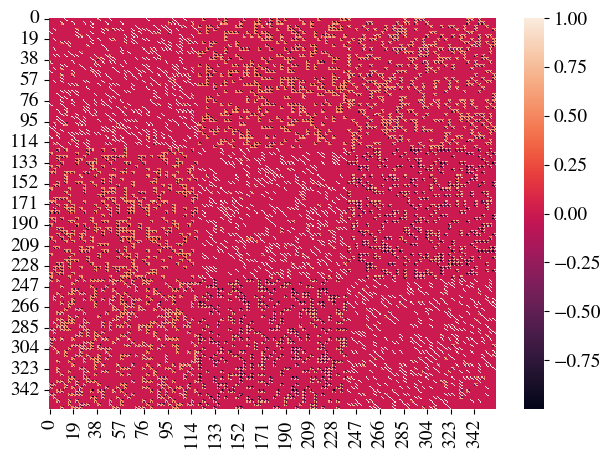

In [308]:
sns.heatmap(A_mat.todense())
plt.show()

In [309]:
d = A.sum(axis=1)
d2 = np.repeat(d, dim).astype(float)
Dinv_mat = diags(1/d2, 0, format='csc')

In [310]:
# matrix transition matrix
P_mat = Dinv_mat @ A_mat

In [313]:
from scipy.sparse.linalg import eigs
vals, vecs = eigs(P_mat, k=12)
print(vals)

[ 0.98356877+0.j  0.9828263 +0.j  0.98204834+0.j  0.27493855+0.j
  0.2741668 +0.j  0.27375181+0.j -0.28611447+0.j -0.28437121+0.j
 -0.28309108+0.j -0.27192697+0.j -0.27002419+0.j -0.26797605+0.j]


In [314]:
# random walk dynamics
from scipy.sparse.linalg import expm

ts_all = np.arange(500)
res = [y_0]

y_tT = y_0.T
for t in ts_all:
    y_tT = y_tT @ P_mat
    res.append(y_tT.T)
#     plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)

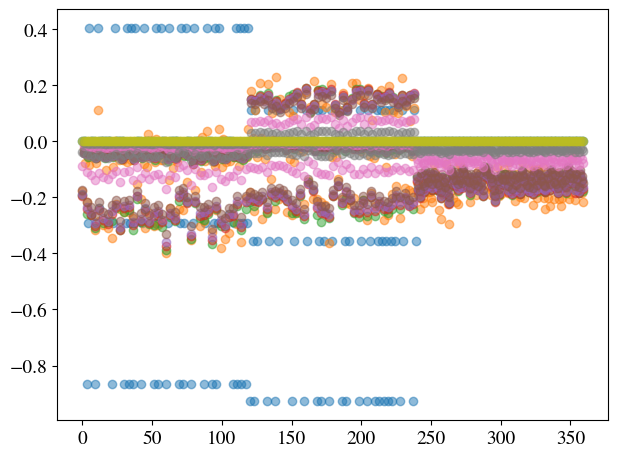

In [329]:
# output the results
ts = [0, 1, 2, 3, 5, 10, 50, 100, 500]
for t in ts:
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

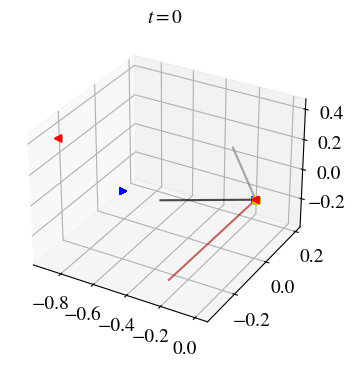

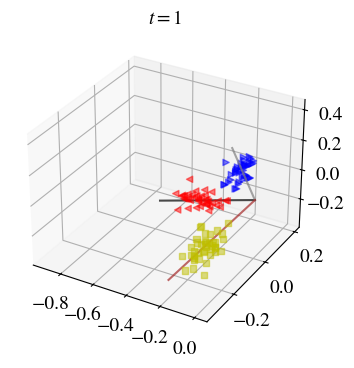

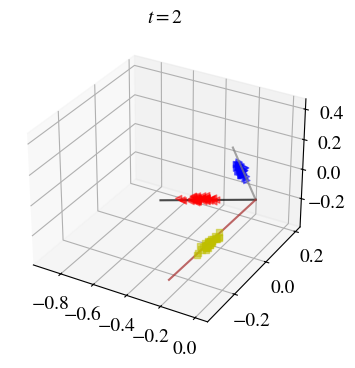

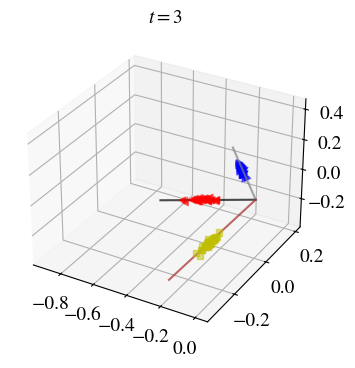

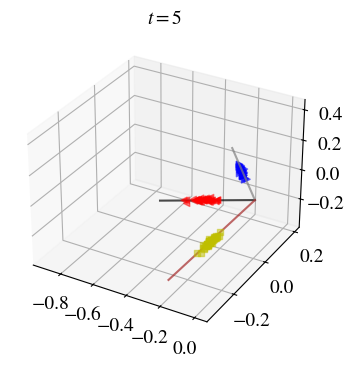

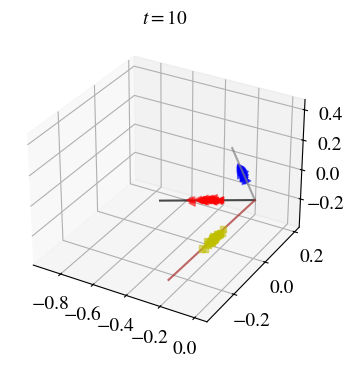

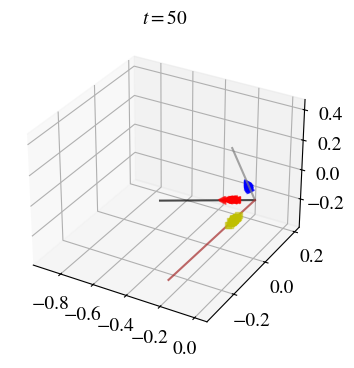

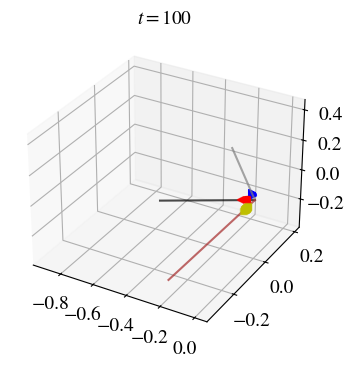

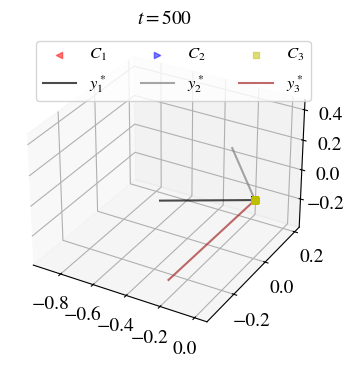

In [330]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
fac = 60
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']
markers = ['<', '>', 's']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(2):
# for ti in range(len(ts)-5, len(ts)):
for ti in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    t = ts[ti]
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], 
                   color=colors[c], marker=markers[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.plot3D([0, y_star[c][0]*fac], 
                  [0, y_star[c][1]*fac],
                  [0, y_star[c][2]*fac], 
                  color=colors_m[c], label=r'$y_{}^*$'.format(c+1), alpha=0.7)
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(t))
    ax.set_xlim([-0.95, 0.05])
    ax.set_ylim([-0.35, 0.22])
    ax.set_zlim([-0.38, 0.45])
    if ti == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('rw-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, ti), dpi=300, bbox_inches='tight')
    plt.show()
# 

#### reducing p_out

In [364]:
# randomly remove edges from g
pout2 = [0.1, 0.03, 0.01][1]
pcut = (pout - pout2)/pout
print("edges to cut:", pcut)

edges to cut: 0.9000000000000001


In [365]:
g2 = g.copy()
edges_out = [(k,l) for k,l in zip(src, trg) if membership[k] != membership[l]]
print("#edges out:", len(edges_out))
n_cut = int(len(edges_out)*pcut)
print("#edges to cut", n_cut)

#edges out: 1432
#edges to cut 1288


In [366]:
from random import sample

ind_cut = sample(range(len(edges_out)), n_cut)
edges_cut = [edges_out[k] for k in ind_cut]
g2.remove_edges_from(edges_cut)

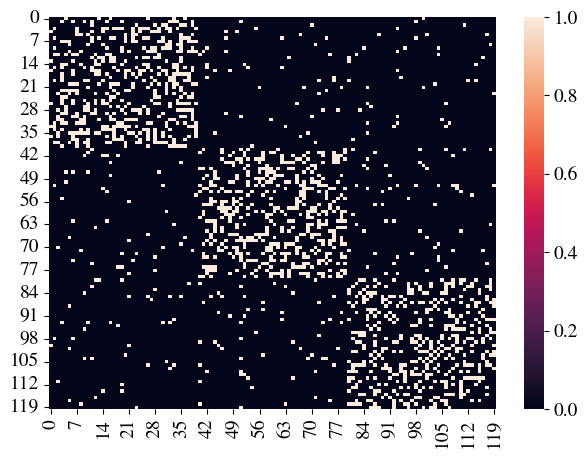

In [367]:
A2 = nx.to_scipy_sparse_array(g2)
sns.heatmap(A2.todense())
plt.show()

In [368]:
# degree matrix
from scipy.sparse import diags

d = A2.sum(axis=1)
d2 = np.repeat(d, dim).astype(float)
Dinv_mat = diags(1/d2, 0, format='csc')

In [369]:
src2, trg2, _ = sparse.find(sparse.triu(A2, 1)) # only edges

In [370]:
coherence = .8
noise = 0.1

In [371]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src2, trg2):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (1, 2), noise angle: -0.06556716454597088 pi
planes: (0, 1), noise angle: -0.18138200100926263 pi
planes: (0, 2), noise angle: 0.02716160785236854 pi
planes: (0, 1), noise angle: 0.049738358770009525 pi
planes: (1, 2), noise angle: 0.17016356691608958 pi
planes: (0, 2), noise angle: -0.11955607562898929 pi
planes: (0, 2), noise angle: -0.18521023200477693 pi
planes: (0, 1), noise angle: -0.24996310028622692 pi
planes: (1, 2), noise angle: 0.07287380381569644 pi
planes: (0, 1), noise angle: -0.004507621026700414 pi
planes: (0, 2), noise angle: 0.051362042192970137 pi
planes: (1, 2), noise angle: -0.0673225489755037 pi
planes: (1, 2), noise angle: -0.044481549349118625 pi
planes: (0, 2), noise angle: -0.22790978500937223 pi
planes: (0, 1), noise angle: -0.04440518469810618 pi
planes: (0, 1), noise angle: -0.09242552569526823 pi
planes: (1, 2), noise angle: -0.012061002848993595 pi
planes: (0, 2), noise angle: 0.00874355858705309 pi
planes: (1, 2), noise angle: -0.0326555347160749

In [372]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

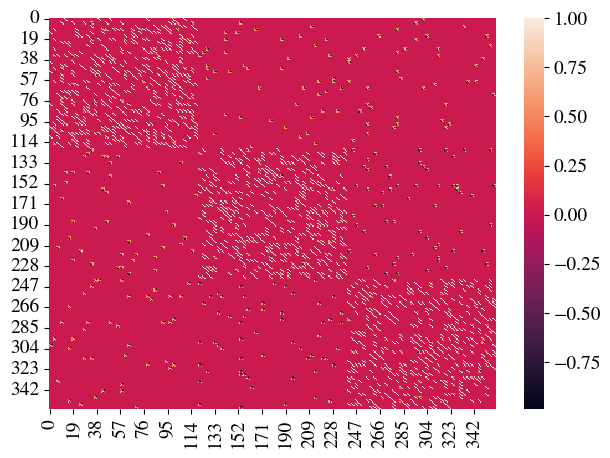

In [373]:
sns.heatmap(A_mat.todense())
plt.show()

In [374]:
# matrix transition matrix
P_mat = Dinv_mat @ A_mat

In [375]:
from scipy.sparse.linalg import eigs
vals, vecs = eigs(P_mat, k=12)
print(vals)

[ 0.98292541+0.j  0.98167741+0.j  0.98021833+0.j  0.78807719+0.j
  0.78686311+0.j  0.78496747+0.j  0.7525104 +0.j  0.75162215+0.j
  0.7502538 +0.j -0.47264059+0.j -0.46980926+0.j -0.47130982+0.j]


In [361]:
# random walk dynamics
from scipy.sparse.linalg import expm

ts_all = np.arange(500)
res = [y_0]

y_tT = y_0.T
for t in ts_all:
    y_tT = y_tT @ P_mat
    res.append(y_tT.T)
#     plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)

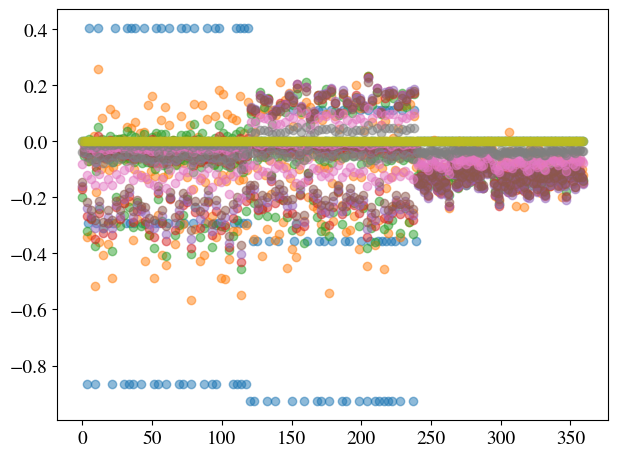

In [362]:
# output the results
ts = [0, 1, 2, 3, 5, 10, 50, 100, 500]
for t in ts:
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

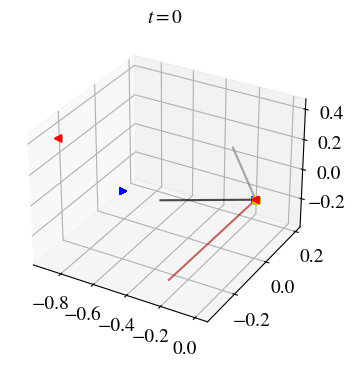

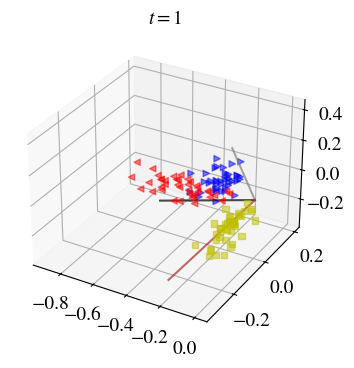

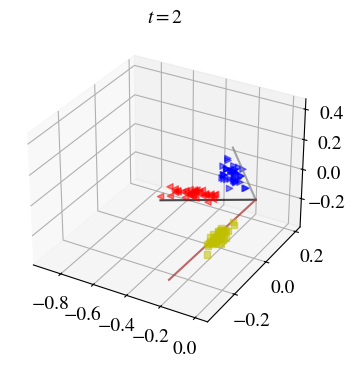

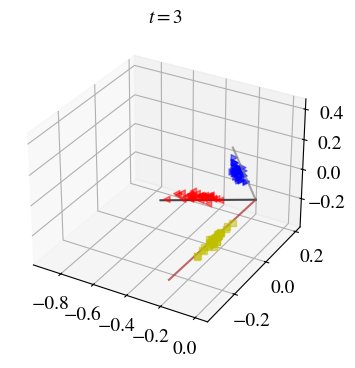

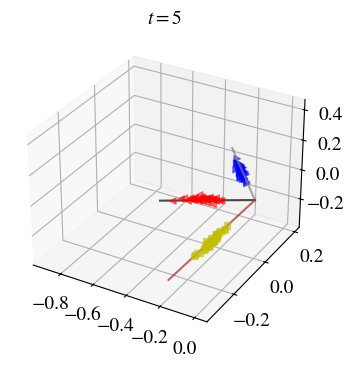

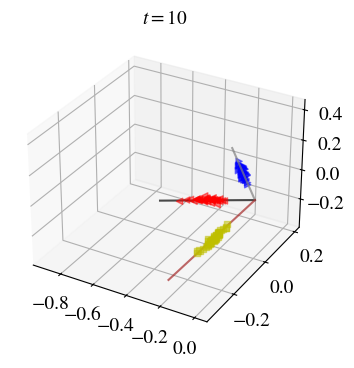

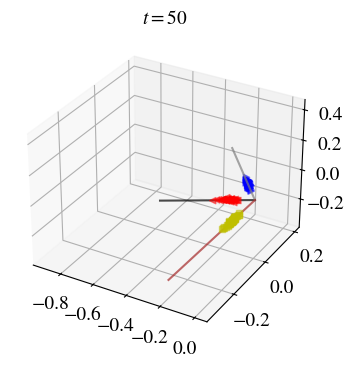

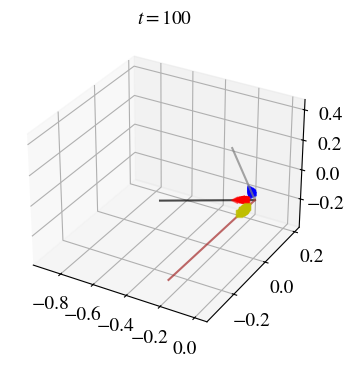

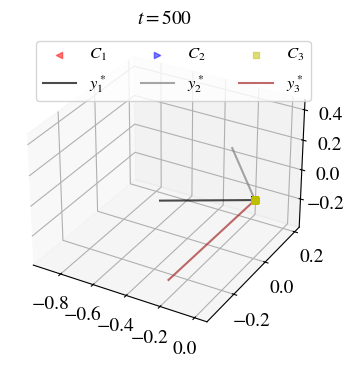

In [363]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
fac = 60
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']
markers = ['<', '>', 's']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(2):
# for ti in range(len(ts)-5, len(ts)):
for ti in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()
    
    t = ts[ti]
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], 
                   color=colors[c], marker=markers[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.plot3D([0, y_star[c][0]*fac], 
                  [0, y_star[c][1]*fac],
                  [0, y_star[c][2]*fac], 
                  color=colors_m[c], label=r'$y_{}^*$'.format(c+1), alpha=0.7)
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(t))
    ax.set_xlim([-0.95, 0.05])
    ax.set_ylim([-0.35, 0.22])
    ax.set_zlim([-0.38, 0.45])
    if ti == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('rw-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout2, coherence, ti), dpi=300, bbox_inches='tight')
    plt.show()
# 